# Download

In [7]:
folder='data/embryo/dataset/'
matrix='chimera_wt_data.tar.gz'

In [8]:
!mkdir -p $folder

In [16]:
!curl https://content.cruk.cam.ac.uk/jmlab/$matrix > $folder/$matrix && cd $folder && tar -xzvf $matrix

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  196M  100  196M    0     0  1344k      0  0:02:30  0:02:30 --:--:-- 1383k
chimera-wt/
chimera-wt/meta.tab
chimera-wt/._meta.tab
chimera-wt/raw_counts.mtx
chimera-wt/sizefactors.tab
chimera-wt/corrected_pcas.rds
chimera-wt/genes.tsv
chimera-wt/README.txt
chimera-wt/._README.txt


In [19]:
matrix='atlas_data.tar.gz'
!curl https://content.cruk.cam.ac.uk/jmlab/$matrix > $folder/$matrix && cd $folder && tar -xzvf $matrix

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1592M  100 1592M    0     0  1355k      0  0:20:03  0:20:03 --:--:-- 1365k
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
atlas/
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
atlas/corrected_pcas.rds
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
atlas/genes.tsv
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended hea

In [20]:
matrix='chimera_tal1_data.tar.gz'
!curl https://content.cruk.cam.ac.uk/jmlab/$matrix > $folder/$matrix && cd $folder && tar -xzvf $matrix

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  572M  100  572M    0     0  1354k      0  0:07:13  0:07:13 --:--:-- 1352k
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
chimera-tal1/
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
chimera-tal1/corrected_pcas.rds
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
chimera-tal1/genes.tsv
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring

In [23]:
!rm -rf data/embryo/dataset/*.tar.gz

# Read and preprocess

In [24]:
import disentangler as dt
from disentangler.dependencies import *

In [25]:
def read_matrix(path):
    
    atlas_mtx = sc.read_mtx(path + 'raw_counts.mtx').T

    atlas_obs = pd.read_csv(path + 'meta.tab', sep = '\t')
    atlas_genes = pd.read_csv(path + 'genes.tsv', header = None, sep = '\t')

    atlas_genes.columns = ['ensemble','gene_symbol']
    atlas_genes.gene_symbol = atlas_genes.gene_symbol.str.upper()

    atlas = anndata.AnnData(
        X = atlas_mtx.X,
        obs = atlas_obs.set_index('barcode'),
        var = atlas_genes.set_index('gene_symbol'),
    )

    atlas.var_names_make_unique()
    
    return atlas

In [29]:
atlas = read_matrix(folder + 'atlas/')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [30]:
chimera_wt = read_matrix(folder + 'chimera-wt/')

In [31]:
chimera_tal = read_matrix(folder + 'chimera-tal1/')

In [32]:
data = anndata.concat({
            'atlas' : atlas,
            'chimera-wt' : chimera_wt,
            'chimera-ko' : chimera_tal,
        }, label = 'experiment', index_unique=':',
        join = 'outer',
    )

data.obs_names_make_unique()

In [33]:
data = data[(data.obs.doublet != True) & (data.obs.stripped != True)]
data.obs = data.obs.drop(columns = ['doublet','stripped'])

In [34]:
data

AnnData object with n_obs × n_vars = 185915 × 29453
    obs: 'cell', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'tomato', 'stage.mapped', 'celltype.mapped', 'haem_closestcell', 'haem_subcluster', 'experiment'

In [35]:
data.var['MT-gene'] = data.var_names.str.startswith('MT')
data.var['pseudogene'] = data.var_names.str.startswith('GM')

In [36]:
sc.pp.filter_genes(data, min_cells = 50)

sc.pp.calculate_qc_metrics(data, log1p=False, inplace=True,
                          qc_vars = ['MT-gene'], percent_top=None)

In [37]:
data = data[:, ~(data.var['MT-gene'] | data.var['pseudogene'])]

In [38]:
data.raw = data

sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)

sc.pp.highly_variable_genes(data, min_disp= 0.)
data.var.highly_variable.sum()

data.var['exog'] = data.var.highly_variable.copy()
data.var['endog'] = data.var.exog & (data.var.dispersions_norm > 0.5)

data.layers['counts'] = data.raw.to_adata().X

model_data = data[:, data.var.exog | data.var.exog]

del data

In [40]:
model_data.obs['sequencing.batch'] = model_data.obs['sequencing.batch'].fillna(4.)
model_data.obs['sequencing.batch'][model_data.obs.experiment == 'chimera-ko']+=1

model_data.obs['batch_id'] = model_data.obs['sequencing.batch'].astype(str)
model_data.obs['day'] = model_data.obs.stage.str.strip('E').replace('mixed_gastrulation','0.0').astype(float)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
problem_columns = model_data.obs.columns[model_data.obs.isna().any(0)]
problem_cols_df = model_data.obs[problem_columns].copy()
problem_cols_df.to_csv(folder + 'metadata.tsv', sep = '\t')

In [81]:
model_data.obs = model_data.obs.iloc[:,~model_data.obs.columns.isin(problem_columns)]
model_data.write_h5ad(folder + 'anndata.h5ad')

# Read

In [1]:
import disentangler as dt
from disentangler.dependencies import *
folder='data/embryo/dataset/'

In [2]:
model_data = anndata.read_h5ad(folder + 'anndata.h5ad')
meta = pd.read_csv(folder + 'metadata.tsv', sep = '\t')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,7,8,13,16,21,22,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
model_data.obs = model_data.obs.join(meta.set_index('barcode'))

In [4]:
!mkdir -p figure3

In [447]:
model_data.obs['Tal1 -/-'] = model_data.obs['tomato'].fillna('-').astype(str).map({'False' : '-', 'True' : '+', '-' : '-'})

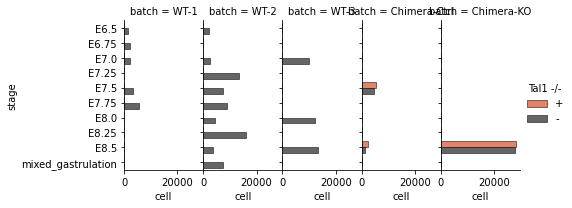

In [450]:
batch_v_stage = model_data.obs.groupby(['sequencing.batch','stage','Tal1 -/-']).count()['cell'].reset_index()
#batch_v_stage['clipped_cell'] = np.clip(batch_v_stage.cell,0., 2e4)

batch_v_stage['batch'] = batch_v_stage['sequencing.batch'].map({1.0 : 'WT-1', 2.0 : 'WT-2', 3.0 : 'WT-3',
                                      4.0 : 'Chimera-Ctrl', 5.0 : 'Chimera-KO'})

sns.catplot(
    data = batch_v_stage,
    col='batch',
    y='stage',
    x = 'cell',
    kind='bar',
    order = sorted(batch_v_stage.stage.unique().astype(str)),
    palette= {'+' : sns.color_palette('RdGy', n_colors=7)[1], '-' : sns.color_palette('RdGy')[-1]},
    hue = 'Tal1 -/-',
    aspect = 0.5,
    height = 3.,
    linewidth = 0.5,
    edgecolor = 'black',
    saturation = 1.,
    dodge = True,
    facet_kws = dict(gridspec_kws = dict(wspace = 0.)),
)
plt.savefig('figure3/batch_cell_heatmap.svg')

batch_v_stage = np.log10(batch_v_stage + 1)

sns.heatmap(batch_v_stage[sorted(batch_v_stage.columns[:-1], key = lambda x : float(x[1:]))], cmap='Greys',
           vmin = 2.5)

plt.savefig('figure3/batch_cell_heatmap.svg')

In [6]:
celltype_palette = {k : '#' + v if type(v) == str else '#EEEEEE' for k,v in dict(model_data.obs[['celltype','colour']].drop_duplicates().values).items()}

celltype_umap_kwargs = dict(
    color = 'celltype', frameon=False, legend_loc='none',
    palette=celltype_palette, title = '',
)

day_umap_kwargs = dict(frameon = False, 
                       color_map = sns.color_palette('mako_r', as_cmap=True), title = '',
                       vmin = 6.5, vmax = 9.1, legend_loc='none', color = 'day')

batch_palette = dict(zip(
    ['5.0','2.0', '3.0','1.0','4.0'],#model_data.obs.groupby('batch_id').count()['cell'].sort_values().index.values,
    sns.color_palette('Set1', n_colors=5)
))

batch_umap_kwargs = dict(
    color = 'batch_id', palette = batch_palette, frameon = False, title = '', 
    legend_loc = 'none',
)

# PCA plot

In [11]:
sc.tl.pca(model_data, n_comps=50, use_highly_variable=True)

In [12]:
sc.pp.neighbors(model_data, n_pcs=50, n_neighbors = 15)
sc.tl.umap(model_data, min_dist = 0.1, negative_sample_rate=3)

In [13]:
!mkdir -p figure3/pca/

... storing 'theiler' as categorical
... storing 'celltype' as categorical
... storing 'colour' as categorical
... storing 'haem_subclust' as categorical
... storing 'endo_trajectoryName' as categorical
... storing 'endo_gutCluster' as categorical
... storing 'stage.mapped' as categorical
... storing 'celltype.mapped' as categorical
... storing 'haem_closestcell' as categorical
... storing 'haem_subcluster' as categorical


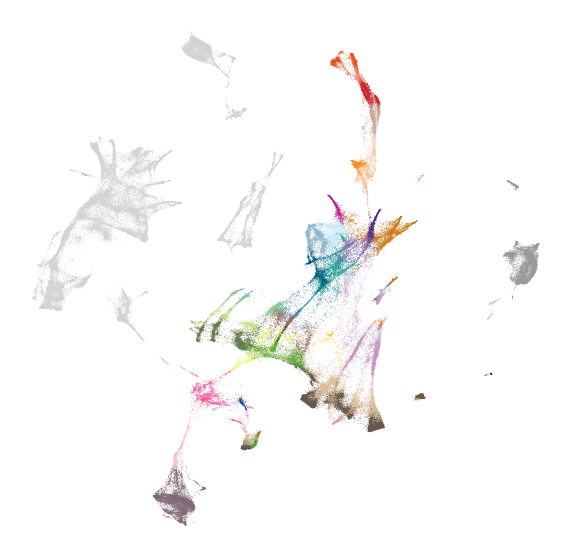

<Figure size 432x288 with 0 Axes>

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.umap(model_data, **celltype_umap_kwargs, ax = ax, s = 1.5)
plt.savefig('figure3/pca/celltypes.png', bbox_inches = 'tight', dpi = 300)

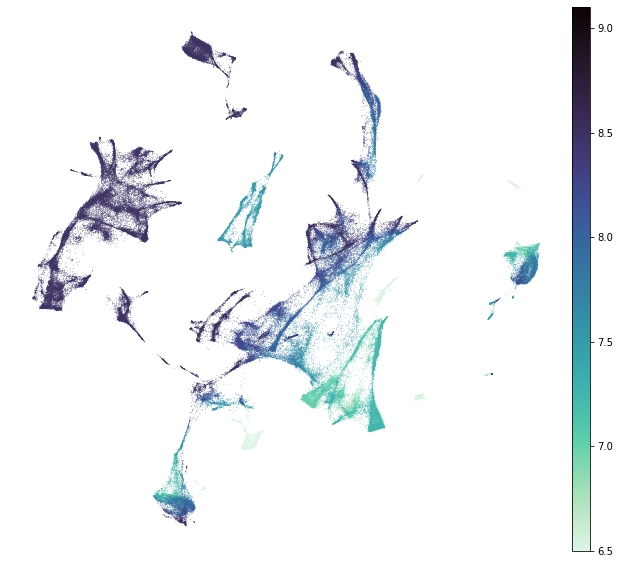

<Figure size 432x288 with 0 Axes>

In [15]:
fig, ax = plt.subplots(1,1,figsize=(11,10))
sc.pl.umap(model_data, ax = ax, **day_umap_kwargs, s = 1.5)
plt.savefig('figure3/pca/day.png', bbox_inches = 'tight', dpi = 300)

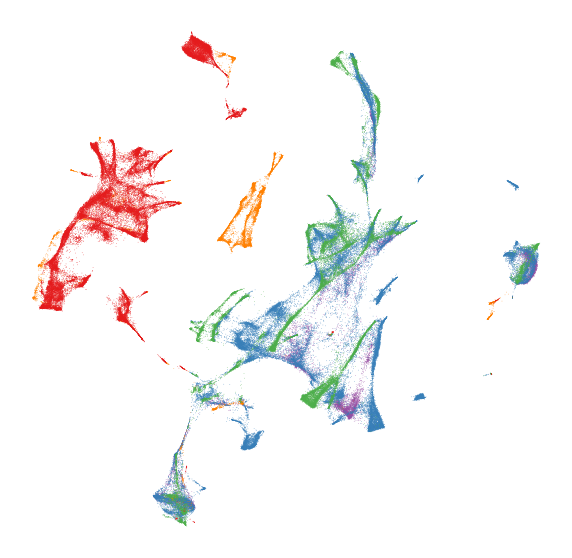

<Figure size 432x288 with 0 Axes>

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.umap(model_data, ax = ax, **batch_umap_kwargs, s= 1.5)
plt.savefig('figure3/pca/batch.png', bbox_inches = 'tight', dpi = 300)

# MIRA

In [7]:
model_data.obs['is_chimera'] = model_data.obs['experiment'].str.startswith('chimera')
model_data.obs['is_mixed_embryos'] = model_data.obs.stage == 'mixed_gastrulation'

In [8]:
model_data.obs['batch-stage-group'] = list(map(lambda b : '{}-{}'.format(*b), model_data.obs[['batch_id','stage']].values))

In [32]:
model = mira.topics.TopicModel(
    *model_data.shape,
    seed = 0,
    categorical_covariates=['batch_id','is_chimera','is_mixed_embryos'],
    continuous_covariates=['day'],
    exogenous_key='exog',
    latent_space='dirichlet',
    feature_type='expression',
    counts_layer='counts',
    min_learning_rate = 1e-3,
    max_learning_rate = 0.1,    
)

In [10]:
model_data.obs['batch-stage-group'] = list(map(lambda b : '{}-{}'.format(*b), model_data.obs[['batch_id','stage']].values))

train, test = mira.topics.SpeedyTuner.train_test_split(model_data, stratify=model_data.obs_vector('batch-stage-group'),
                                                      train_size = 0.9)

!rm -rf $folder/full_train $folder/full_test

model.write_ondisk_dataset(train, dirname= folder + 'full_train')
model.write_ondisk_dataset(test, dirname= folder + 'full_test')

del train, test

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog


Writing dataset to disk:   0%|          | 0/164 [00:00<?, ?it/s]

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog


Writing dataset to disk:   0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
tuner = mira.topics.SpeedyTuner(
    model = model,
    min_trials = 64,
    max_trials = 128,
    min_topics = 35,
    max_topics = 80,
    stop_condition=12,
    n_jobs=15,
    storage=mira.topics.Redis(),
    save_name = 'embryo/rna/final/2'
)

tuner.purge()

tuner.fit(folder + 'full_train',
          folder + 'full_test')

In [134]:
print(tuner)

Trials finished: 79 | Best trial: 45 | Best score: 1.7719e+03
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/embryo/rna/final/2
#Topics | #Trials 

     35 | ■ 
     36 | ■ 
     38 | ■ 
     39 | ■ 
     41 | ■ ■ 
     44 | ■ 
     45 | ■ ■ 
     46 | ■ 
     47 | ■ ■ 
     49 | ■ ■ 
     50 | ■ ■ 
     51 | ■ ■ ■ 
     54 | ■ ■ 
     56 | ■ ■ ■ 
     58 | ■ ■ ■ 
     59 | ■ ■ ■ ■ ■ ■ ■ 
     60 | ■ 
     61 | ■ ■ ■ 
     63 | ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
     64 | ■ ■ ■ ■ 
     66 | ■ ■ ■ 
     67 | ■ ■ ■ 
     68 | ■ 
     69 | ■ ■ 
     70 | ■ ■ ■ 
     71 | ■ ■ 
     73 | ■ ■ ■ ■ ■ 
     74 | ■ 
     76 | ■ 
     77 | ■ 
     78 | ■ 
     80 | ■ ■ 

Trial | Result (● = best so far)         | Params
 #13  |   | pruned at step: 8            | {'num_topics': 74, 'decoder_dropout': 0.1102}
 #12  |   | pruned at step: 8            | {'num_topics': 56, 'decoder_dropout': 0.1207}
 #11  |   | completed, score: 1.7744e+03 | {'num_topics': 68, 'd

In [126]:
model = tuner.fetch_weights(41)

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


model = mira.topics.load_model('data/embryo/main_model.pth')

In [127]:
model.predict(model_data)

Predicting latent vars:   0%|          | 0/727 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31, topic_32, topic_33, topic_34, topic_35, topic_36, topic_37, topic_38, topic_39, topic_40, topic_41, topic_42, topic_43, topic_44, topic_45, topic_46, topic_47, topic_48, topic_49, topic_50, topic_51, topic_52, topic_53, topic_54, topic_55, topic_56, topic_57, topic_58, topic_59, topic_60, topic_61, topic_62
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [128]:
model.get_umap_features(model_data, box_cox=0.1)
sc.pp.neighbors(model_data, use_rep='X_umap_features', metric = 'manhattan')
sc.tl.umap(model_data, min_dist=0.1 ,negative_sample_rate=3)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [140]:
old_coors = model_data.obsm['X_umap']
model_data.obsm['adj_umap'] = \
    np.where((old_coors[:,0] < 1)[:,None], old_coors + np.array([[5, 0]]), old_coors)

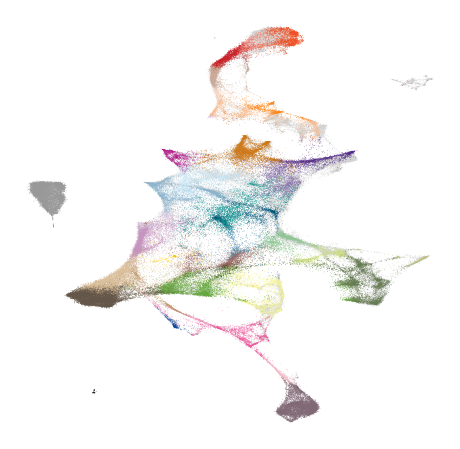

<Figure size 432x288 with 0 Axes>

In [143]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, **celltype_umap_kwargs, ax = ax, basis = 'adj_umap', s= 1.5)
plt.savefig('figure3/main/celltypes.png', bbox_inches = 'tight', dpi = 300)

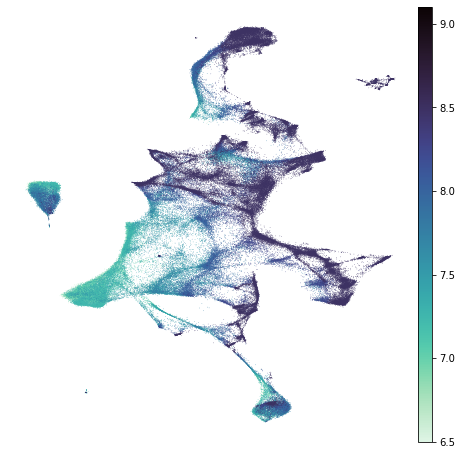

<Figure size 432x288 with 0 Axes>

In [144]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, **day_umap_kwargs, ax = ax, basis = 'adj_umap', s= 1.5)
plt.savefig('figure3/main/day.png', bbox_inches = 'tight', dpi = 300)

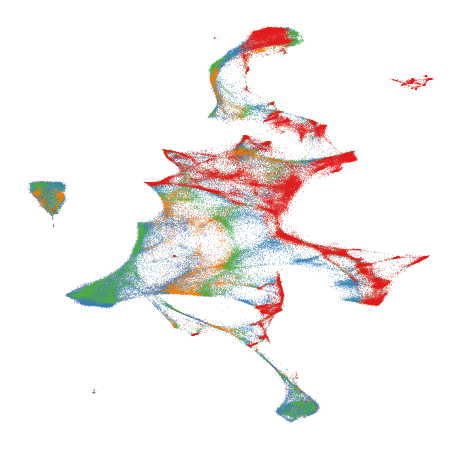

<Figure size 432x288 with 0 Axes>

In [145]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, **batch_umap_kwargs, ax = ax, basis = 'adj_umap', s= 1.5)
plt.savefig('figure3/main/batch.png', bbox_inches = 'tight', dpi = 300)

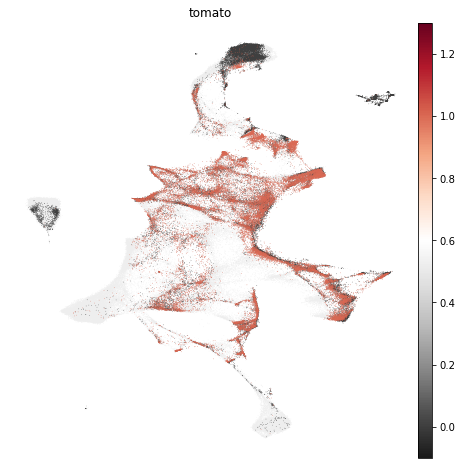

In [146]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, na_color='#EEEEEE', basis = 'adj_umap',
          frameon=False, color_map='RdBu_r', ax= ax, size = 1.5, show = False)

sc.pl.embedding(model_data[model_data.obs.is_chimera], color = 'tomato', vmax = 1.3, vmin = -0.1,
          frameon=False, color_map='RdGy_r', ax= ax, size = 1.5, show = False, basis = 'adj_umap')

plt.savefig('figure3/main/tomato_overlay.png', bbox_inches = 'tight', dpi = 300)

In [160]:
!mkdir -p sup3

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


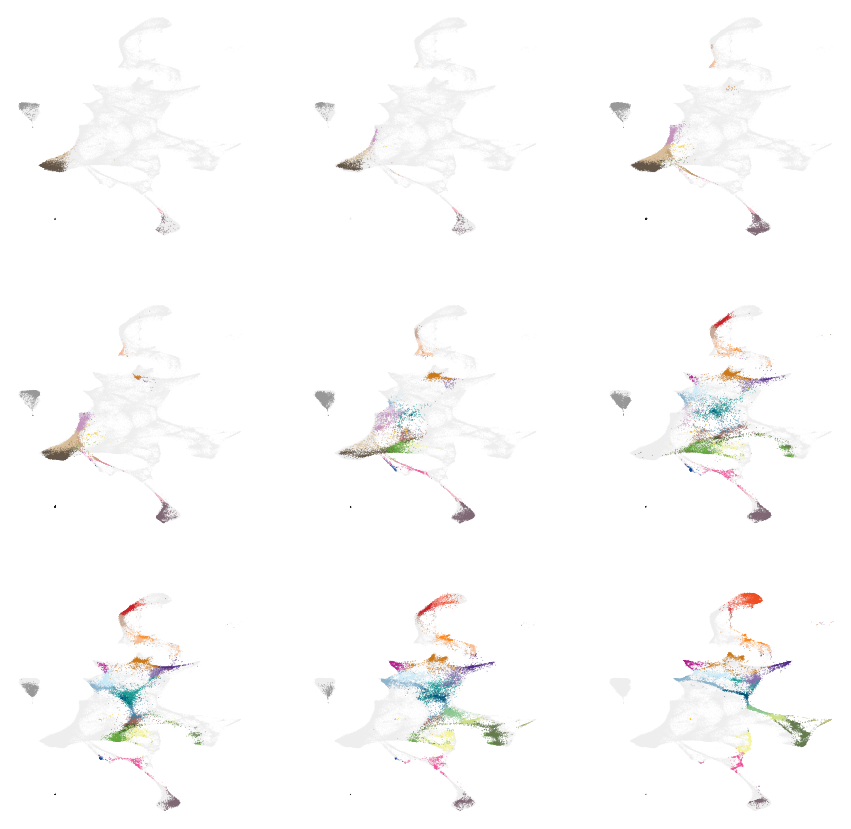

In [161]:
from collections import defaultdict

day_order = sorted(model_data.obs.day.unique())[1:]
fig, ax = plt.subplots(3, len(day_order)//3, figsize = (15, 15))
palette = sns.color_palette('mako_r', len(day_order))

for ax_, day, color in zip(np.ravel(ax), day_order, palette):
    #& ~(model_data.obs.celltype.astype(str) == 'ExE ectoderm')
    sc.pl.embedding(model_data[(~model_data.obs.is_chimera)], size = 1, ax = ax_, show = False, frameon = False,
               na_color = '#EEEEEE', legend_loc= 'none', wspace=0, title = '', basis = 'adj_umap',
               legend_fontweight=200, legend_fontsize=10, palette=defaultdict(lambda : '#EEEEEE')
              )
    
    sc.pl.embedding(model_data[(model_data.obs.day == day) & ~model_data.obs.is_chimera], size = 2, frameon = False,
                    ax = ax_, show = False, color = 'celltype', palette=celltype_palette, legend_loc='none', basis = 'adj_umap',
                   na_color = color, wspace=0., hspace=0., legend_fontsize=8, legend_fontweight=150, title = '')
    
plt.savefig('sup3/celltypes_over_time.png', bbox_inches = 'tight', dpi = 300)

In [164]:
from mira.plots.base import map_plot, plot_umap, map_colors

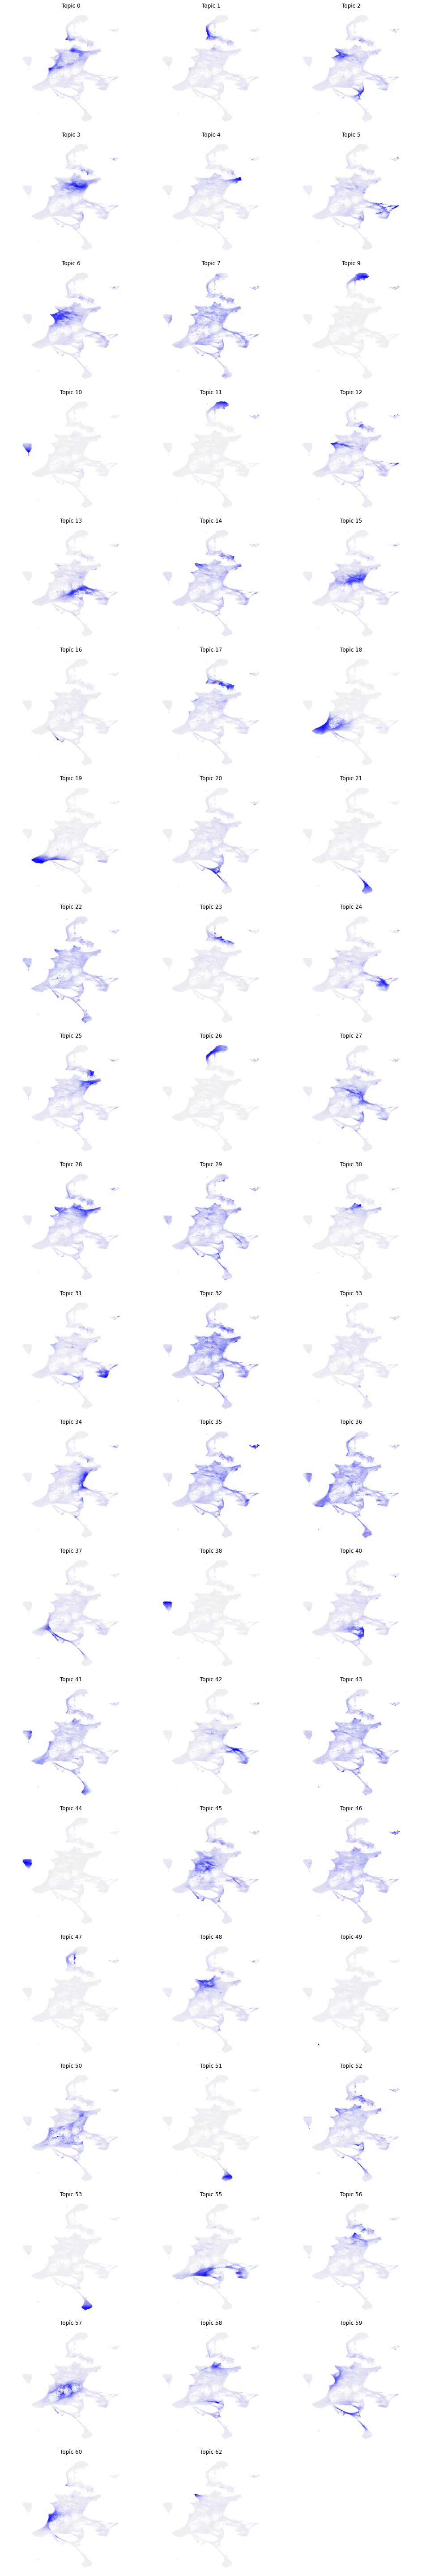

In [682]:
def topic_umap(ax, topic):
    
    ax = plot_umap(
        model_data.obsm['adj_umap'],
        model_data.obs_vector(topic),
        palette=sns.color_palette('light:blue', as_cmap=True),
        figsize=(5,5),
        size = 0.01,
        add_legend=False,
        vmin=-0.0,
        ax = ax,
        title = 'Topic ' + topic.split('_')[-1]
    )
    ax.set_xmargin(0.2)
    ax.set_xmargin(0.2)

map_plot(topic_umap, 
         [[x] for x, max_c in zip(model.topic_cols, model_data.obsm['X_topic_compositions'].max(0) > 0.1) if max_c], 
         plots_per_row=3, height=4, aspect=1.1)

plt.savefig('figure3/topics.png', bbox_inches = 'tight', dpi = 300)

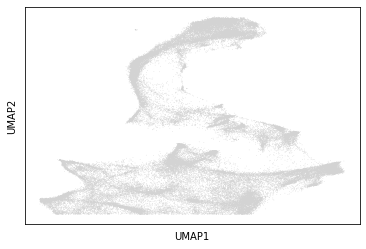

In [330]:
model_data.obs['in_zoomin'] = (model_data.obsm['X_umap'][:,0] > 6.5) & (model_data.obsm["X_umap"][:,1] > 7) & (model_data.obsm["X_umap"][:,0] < 13)
sc.pl.umap(model_data[model_data.obs.in_zoomin])

In [331]:
downsample = model_data[model_data.obs.in_zoomin]

In [332]:
model.predict(downsample)
model.impute(downsample)
model.get_batch_effect(downsample)

Predicting latent vars:   0%|          | 0/268 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31, topic_32, topic_33, topic_34, topic_35, topic_36, topic_37, topic_38, topic_39, topic_40, topic_41, topic_42, topic_43, topic_44, topic_45, topic_46, topic_47, topic_48, topic_49, topic_50, topic_51, topic_52, topic_53, topic_54, topic_55, topic_56, topic_57, topic_58, topic_59, topic_60, topic_61, topic_62
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/268 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/268 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: batch_effect


In [333]:
#Pcolce, Tdo2 and Plagl1, Nkx2–5, Mef2c and Tnnt2

In [475]:
height_mask = (downsample.obsm["X_umap"][:,1] > 8.5)

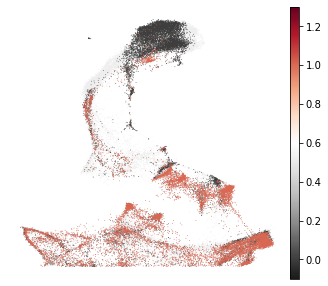

In [476]:
fig, ax = plt.subplots(1,1,figsize=(5.5,5))
sc.pl.embedding(downsample[height_mask], na_color='#EEEEEE', basis = 'adj_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 2.5, show = False, outline_width=(0.,1.01))

sc.pl.embedding(downsample[downsample.obs.is_chimera & height_mask], color = 'tomato', vmax = 1.3, vmin = -0.1, alpha = 1.,
          frameon=False, color_map='RdGy_r', ax= ax, size = 2.5, show = False, basis = 'adj_umap', title = '')

plt.savefig('figure3/main/tomato_inset.png', bbox_inches = 'tight', dpi = 300)

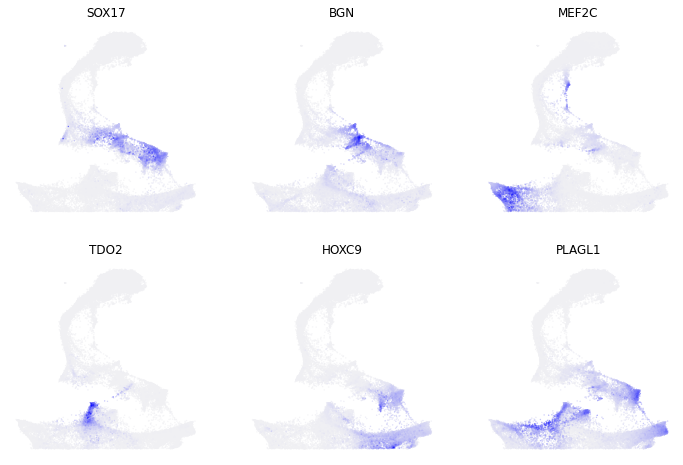

In [624]:
fig, ax = plt.subplots(2,3,figsize=(4*3, 4*2))
    
for gene, _ax in zip('SOX17, BGN, MEF2C, TDO2, HOXC9, PLAGL1'.upper().split(', '), np.ravel(ax)):
    plot_umap(downsample[height_mask].obsm['X_umap'], downsample[height_mask].obs_vector(gene, layer = 'imputed'),
              palette=sns.color_palette('light:blue', as_cmap=True), 
              ax = _ax, size = 0.1, add_legend=False, title = gene)
plt.savefig('figure3/author_genes_of_interest.png', bbox_inches = 'tight', dpi = 300)

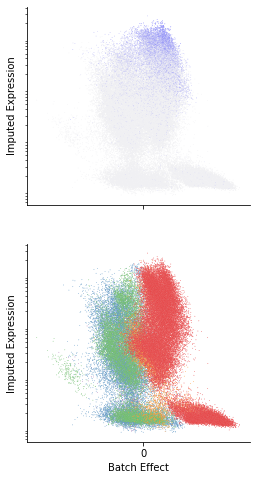

In [632]:
fig, ax = plt.subplots(2,1,figsize=(4,8,), sharex=True)
dt.plots.disentanglement_plot(downsample, ax[1], 'PLAGL1', color= 'batch_id',
                              palette = list(batch_palette.values()),
                              hue_order= list(batch_palette.keys())
                             )

dt.plots.disentanglement_plot(downsample, ax[0], 'PLAGL1', palette = sns.color_palette('light:blue', as_cmap=True))

plt.savefig('figure3/PLAGL1_disentanglement_plot.png',  bbox_inches = 'tight', dpi = 300)

In [523]:
source_cell_mask = (downsample.obs.batch_id.astype(str) == '5.0') & downsample.obs.tomato.astype(bool) & ~downsample.obs.haem_closestcell.isna()
color_cells = downsample.obs.haem_closestcell[
    source_cell_mask & downsample.obs.haem_closestcell.isin(downsample.obs.cell)
].values.astype(str)

is_mapped_cell = downsample.obs['cell'].isin(color_cells)

In [558]:
temp = downsample[is_mapped_cell].copy()

In [559]:
sc.pp.neighbors(temp)

In [567]:
name_to_idx = dict(zip(downsample.obs.cell, range(downsample.n_obs)))

i,j,d=[],[],[]
for row in [row for row, m in zip(downsample.obs.iterrows(), source_cell_mask) if m] :
    if row[1].haem_closestcell in name_to_idx:
        i.append(name_to_idx[row[1].haem_closestcell])
        j.append(name_to_idx[row[1].cell])
        d.append(1.)

In [594]:
X = downsample[i].obsm['adj_umap']
U = downsample[j].obsm['adj_umap'] - X

<AxesSubplot:xlabel='adj_umap1', ylabel='adj_umap2'>

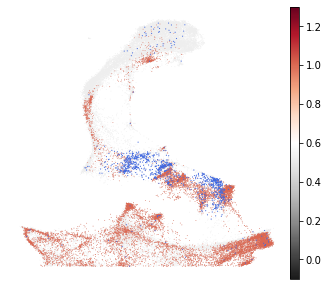

In [685]:
fig, ax = plt.subplots(1,1,figsize=(5.5,5))
sc.pl.embedding(downsample[height_mask], na_color='#EEEEEE', basis = 'adj_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 2.5, show = False, outline_width=(0.,1.01))

sc.pl.embedding(downsample[height_mask & downsample.obs.is_chimera & downsample.obs.tomato > 0], color = 'tomato', vmax = 1.3, vmin = -0.1,
          frameon=False, color_map='RdGy_r', ax= ax, size = 2.5, show = False, basis = 'adj_umap', title = '', alpha = 1.)

sc.pl.embedding(downsample[height_mask & is_mapped_cell], 
                na_color='royalblue', edges = False, #neighbors_key = 'connectivities',
          frameon=False, ax= ax, size = 5, show = False, basis = 'adj_umap', title = '')

#plt.savefig('figure3/main/projected_tal1_cells.png', bbox_inches = 'tight', dpi = 300)

# Confounded MIRA

In [82]:
confounded_design_matrix = {
    '1.0' : ['E6.5','E6.75','E7.0',],
    '2.0' : ['E7.25', 'E7.5','E7.75','E8.25'],
    '3.0' : ['E8.0','E8.5'],
    '4.0' : ['E7.5', 'E8.5'],
    '5.0' : ['E8.5'],
}

model_data.obs['in_confounding_experiment'] = [
    s in confounded_design_matrix[b] and (t == True if b == '5.0' else True)
    for b,s,t in model_data.obs[['batch_id','stage','tomato']].values
]

In [83]:
!mkdir -p figure3/confounded/

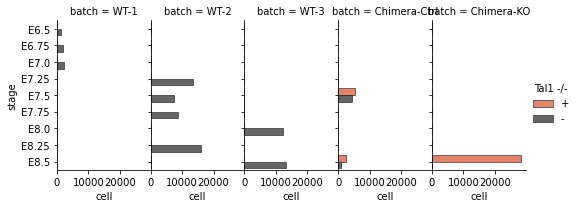

In [451]:
batch_v_stage = model_data[model_data.obs.in_confounding_experiment].obs.groupby(['sequencing.batch','stage','Tal1 -/-']).count()['cell'].reset_index()
#batch_v_stage['clipped_cell'] = np.clip(batch_v_stage.cell,0., 2e4)

batch_v_stage['batch'] = batch_v_stage['sequencing.batch'].map({1.0 : 'WT-1', 2.0 : 'WT-2', 3.0 : 'WT-3',
                                      4.0 : 'Chimera-Ctrl', 5.0 : 'Chimera-KO'})

sns.catplot(
    data = batch_v_stage,
    col='batch',
    y='stage',
    x = 'cell',
    kind='bar',
    order = sorted(batch_v_stage.stage.unique().astype(str)),
    palette= {'+' : sns.color_palette('RdGy', n_colors=7)[1], '-' : sns.color_palette('RdGy')[-1]},
    hue = 'Tal1 -/-',
    aspect = 0.5,
    height = 3.,
    linewidth = 0.5,
    edgecolor = 'black',
    saturation = 1.,
    dodge = True,
    facet_kws = dict(gridspec_kws = dict(wspace = 0.)),
)
plt.savefig('figure3/confounded/batch_cell_heatmap.svg')

In [86]:
confounded_model = mira.topics.TopicModel(
    int(model_data.obs.in_confounding_experiment.sum()), model_data.n_vars,
    categorical_covariates=['batch_id','is_chimera','is_mixed_embryos'],
    continuous_covariates=['day'],
    exogenous_key='exog',
    latent_space='dirichlet',
    feature_type='expression',
    counts_layer='counts',
    min_learning_rate = 0.001,
    max_learning_rate = 0.1,
)

In [88]:
confounded_data = model_data[model_data.obs.in_confounding_experiment]

confounded_data.obs['batch-stage-group'] = list(map(lambda b : '{}-{}'.format(*b), confounded_data.obs[['batch_id','stage']].values))

train, test = mira.topics.SpeedyTuner.train_test_split(confounded_data, stratify=confounded_data.obs_vector('batch-stage-group'), train_size = 0.9)

confounded_model.write_ondisk_dataset(train, dirname=folder+'confounded_train')
confounded_model.write_ondisk_dataset(test, dirname=folder+'confounded_test')

del train, test

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog


Writing dataset to disk:   0%|          | 0/105 [00:00<?, ?it/s]

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog


Writing dataset to disk:   0%|          | 0/12 [00:00<?, ?it/s]

In [89]:
tuner = mira.topics.SpeedyTuner(
    model = confounded_model,
    min_trials = 64,
    max_trials = 128,
    min_topics = 35,
    max_topics = 80,
    stop_condition=12,
    n_jobs=15,
    storage=mira.topics.Redis(),
    save_name = 'embryo/rna/confounded/final/0'
)

tuner.purge()

In [ ]:
tuner.fit(
    folder+'confounded_train',
    folder+'confounded_test'
)

In [91]:
print(tuner)

Trials finished: 81 | Best trial: 48 | Best score: 1.8204e+03
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

Tensorboard logidr: runs/embryo/rna/confounded/final/0
#Topics | #Trials 

     39 | ■ 
     40 | ■ 
     41 | ■ 
     42 | ■ 
     43 | ■ ■ 
     44 | ■ ■ ■ ■ ■ 
     46 | ■ 
     48 | ■ ■ 
     50 | ■ 
     51 | ■ ■ 
     52 | ■ 
     53 | ■ 
     54 | ■ 
     57 | ■ 
     58 | ■ ■ ■ ■ ■ ■ 
     61 | ■ 
     62 | ■ ■ 
     63 | ■ ■ ■ ■ ■ ■ ■ 
     66 | ■ ■ ■ ■ 
     67 | ■ ■ ■ 
     68 | ■ ■ ■ 
     69 | ■ ■ 
     71 | ■ 
     73 | ■ ■ ■ ■ ■ ■ 
     74 | ■ 
     76 | ■ ■ 
     77 | ■ 
     78 | ■ 
     79 | ■ ■ ■ ■ ■ 

Trial | Result (● = best so far)         | Params
 #0   |   | pruned at step: 8            | {'num_topics': 40, 'decoder_dropout': 0.1015}
 #1   |   | pruned at step: 8            | {'num_topics': 79, 'decoder_dropout': 0.1740}
 #5   |   | completed, score: 1.8244e+03 | {'num_topics': 50, 'decoder_dropout': 0.0602}
 #7   |   | pruned at s

<AxesSubplot:xlabel='Num_topics', ylabel='Elbo'>

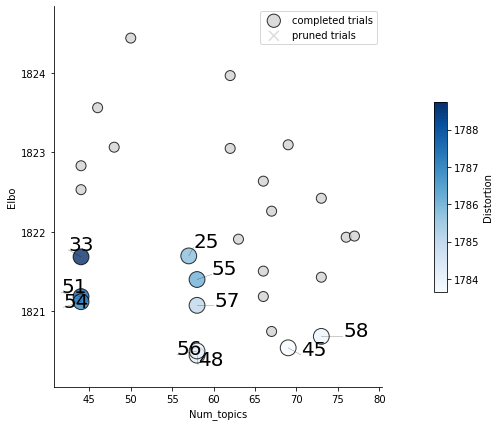

In [92]:
tuner.plot_pareto_front()

In [93]:
confounded_model = tuner.fetch_best_weights()

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [103]:
confounded_model.save('data/embryo/confounded_model.pth')

In [ ]:
confounded_model = mira.topics.load_model('data/embryo/confounded_model.pth')

In [94]:
confounded_model.predict(confounded_data)

Predicting latent vars:   0%|          | 0/464 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31, topic_32, topic_33, topic_34, topic_35, topic_36, topic_37, topic_38, topic_39, topic_40, topic_41, topic_42, topic_43, topic_44, topic_45, topic_46, topic_47, topic_48, topic_49, topic_50, topic_51, topic_52, topic_53, topic_54, topic_55, topic_56, topic_57
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [99]:
confounded_model.get_umap_features(confounded_data, box_cox=0.2)
sc.pp.neighbors(confounded_data, use_rep='X_umap_features', metric = 'manhattan')
sc.tl.umap(confounded_data, min_dist=0.1 ,negative_sample_rate=3)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [646]:
theta = np.pi/10
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [661]:
newcoors = np.dot(confounded_data.obsm["X_umap"] * np.array([[-1,1]]), rot)
confounded_data.obsm['adj_umap'] = np.where((newcoors[:,0] < -5)[:,None], newcoors + np.array([[3, 0]]), newcoors)

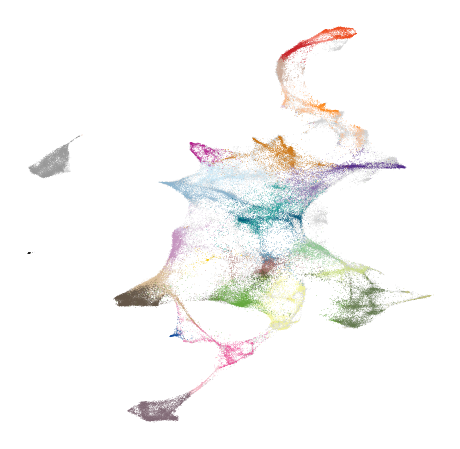

<Figure size 432x288 with 0 Axes>

In [663]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(confounded_data, **celltype_umap_kwargs, ax = ax, basis = 'adj_umap', s= 1.5)
plt.savefig('figure3/confounded/celltypes.png', bbox_inches = 'tight', dpi = 300)

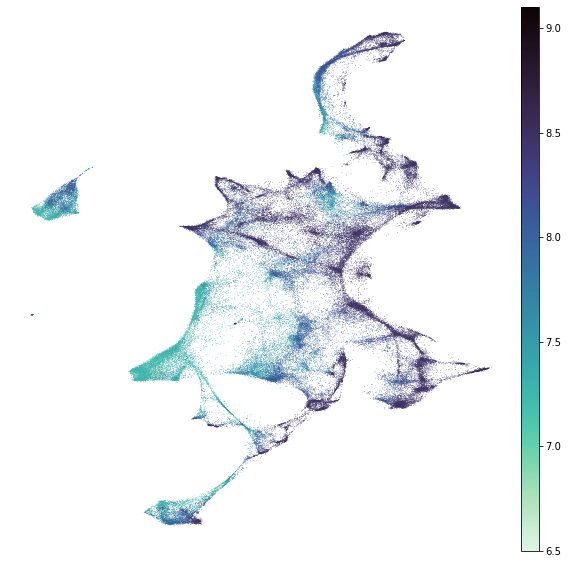

<Figure size 432x288 with 0 Axes>

In [665]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(confounded_data, **day_umap_kwargs, ax = ax, basis = 'adj_umap', s= 1.5)
plt.savefig('figure3/confounded/day.png', bbox_inches = 'tight', dpi = 300)

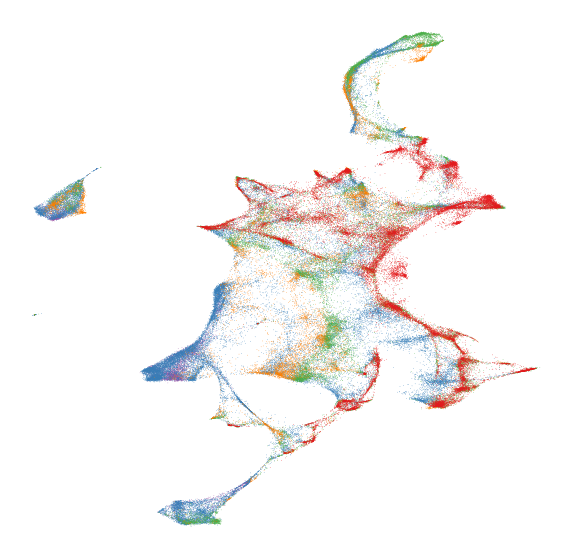

<Figure size 432x288 with 0 Axes>

In [666]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sc.pl.embedding(confounded_data, **batch_umap_kwargs, ax = ax, basis = 'adj_umap', s= 1.5)
plt.savefig('figure3/confounded/batch.png', bbox_inches = 'tight', dpi = 300)

In [667]:
confounded_data.obs['in_downsample'] = confounded_data.obs_names.isin(downsample.obs_names)

In [675]:
confounded_downsample = confounded_data[confounded_data.obs.in_downsample \
                                & (confounded_data.obsm['adj_umap'][:,1] > 10) \
                                & (confounded_data.obsm['adj_umap'][:,0] > -3)]

In [678]:
confounded_model.impute(confounded_downsample)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/158 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added layer: imputed


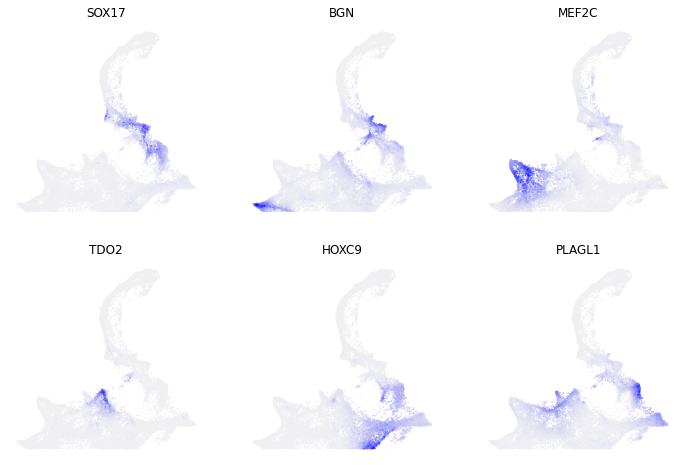

In [680]:
fig, ax = plt.subplots(2,3,figsize=(4*3, 4*2))
    
for gene, _ax in zip('SOX17, BGN, MEF2C, TDO2, HOXC9, PLAGL1'.upper().split(', '), np.ravel(ax)):
    plot_umap(confounded_downsample.obsm['adj_umap'], confounded_downsample.obs_vector(gene, layer = 'imputed'),
              palette=sns.color_palette('light:blue', as_cmap=True), 
              ax = _ax, size = 0.1, add_legend=False, title = gene)
plt.savefig('figure3/confounded/marker_genes.png', bbox_inches = 'tight', dpi = 300)

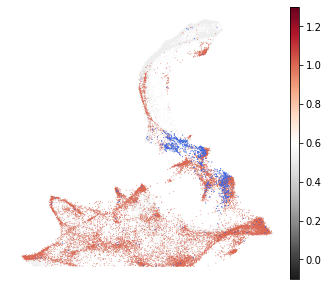

In [687]:
fig, ax = plt.subplots(1,1,figsize=(5.5,5))
sc.pl.embedding(confounded_downsample, na_color='#EEEEEE', basis = 'adj_umap', add_outline= False,
          frameon=False, color_map='RdBu_r', ax= ax, size = 2.5, show = False, outline_width=(0.,1.01))

sc.pl.embedding(confounded_downsample[confounded_downsample.obs.is_chimera & (confounded_downsample.obs.tomato > 0)], color = 'tomato', vmax = 1.3, vmin = -0.1,
          frameon=False, color_map='RdGy_r', ax= ax, size = 2.5, show = False, basis = 'adj_umap', title = '', alpha = 1.)

is_mapped_cell = confounded_downsample.obs['cell'].isin(color_cells)
sc.pl.embedding(confounded_downsample[ is_mapped_cell], 
               na_color='royalblue', edges = False, #neighbors_key = 'connectivities',
              frameon=False, ax= ax, size = 5, show = False, basis = 'adj_umap', title = '')

plt.savefig('figure3/confounded/projected_neighbors.png', bbox_inches = 'tight', dpi = 300)

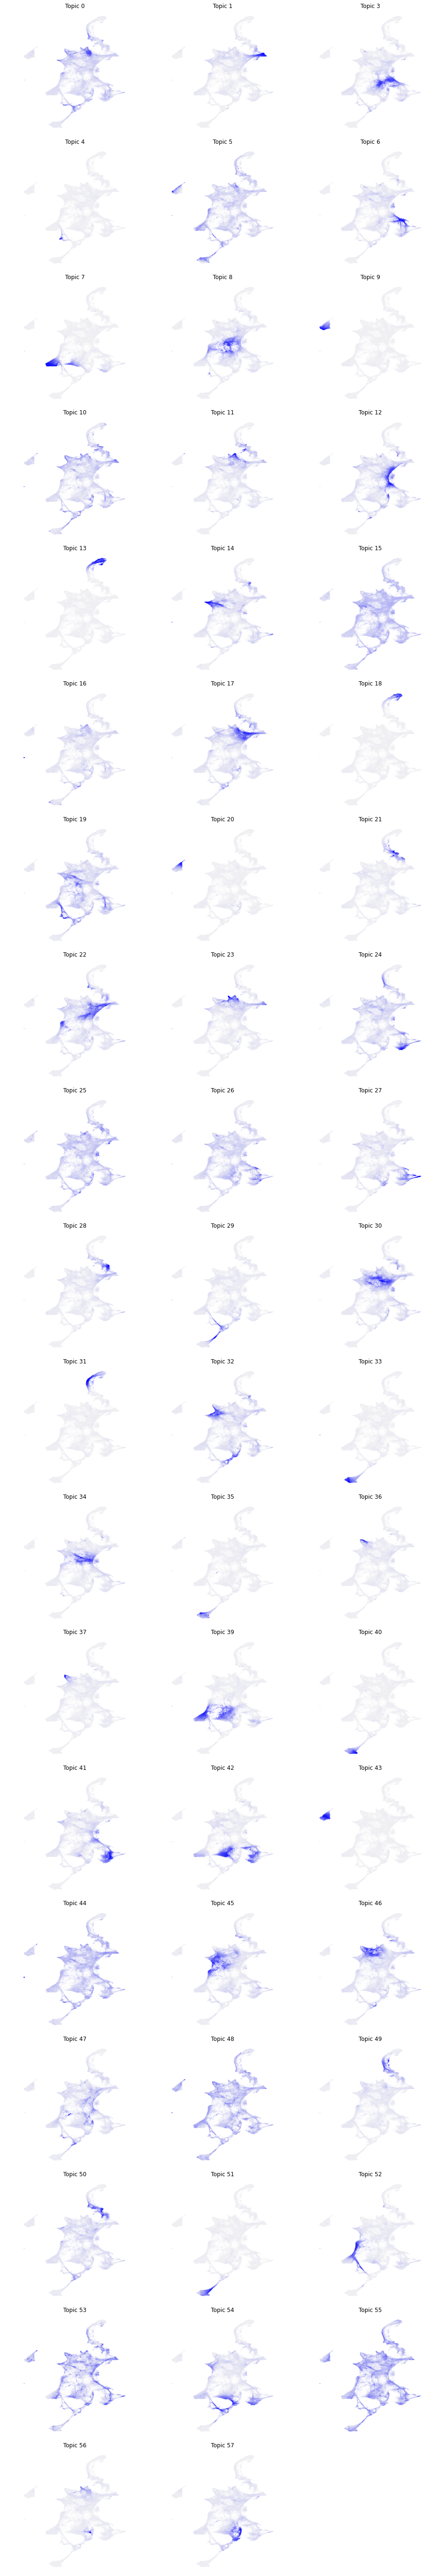

In [681]:
def topic_umap(ax, topic):
    
    ax = plot_umap(
        confounded_data.obsm['adj_umap'],
        confounded_data.obs_vector(topic),
        palette=sns.color_palette('light:blue', as_cmap=True),
        figsize=(5,5),
        size = 0.01,
        add_legend=False,
        vmin=-0.0,
        ax = ax,
        title = 'Topic ' + topic.split('_')[-1]
    )
    ax.set_xmargin(0.2)
    ax.set_xmargin(0.2)

map_plot(topic_umap, 
         [[x] for x, max_c in zip(model.topic_cols, confounded_data.obsm['X_topic_compositions'].max(0) > 0.1) if max_c], 
         plots_per_row=3, height=4, aspect=1.1)

plt.savefig('figure3/confounded/topics.png', bbox_inches = 'tight', dpi = 300)

# Author's manifold

In [688]:
model_data.obsm['X_author_umap'] = model_data.obs[['umapX', 'umapY']].values.copy()

In [689]:
!mkdir -p figure3/author

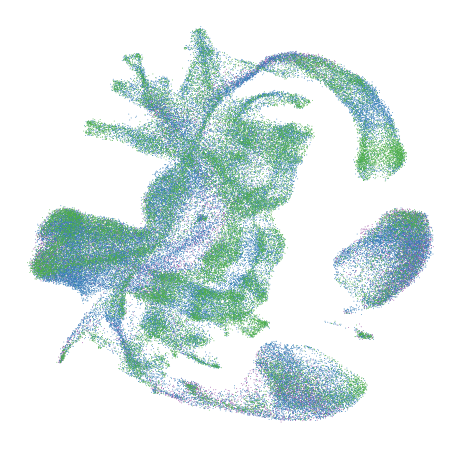

<Figure size 432x288 with 0 Axes>

In [694]:
def convert_kwargs(kwargs):
    kwargs.pop('s')
    kwargs['s'] = 8
    return kwargs

fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, ax = ax, **batch_umap_kwargs, s = 3, basis = 'X_author_umap')
plt.savefig('figure3/author/batch.png', bbox_inches = 'tight', dpi = 300)

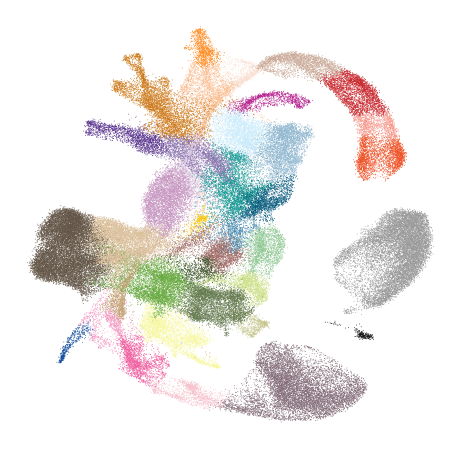

<Figure size 432x288 with 0 Axes>

In [695]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, ax = ax, **celltype_umap_kwargs, s =3, basis = 'X_author_umap')
plt.savefig('figure3/author/celltypes.png', bbox_inches = 'tight', dpi = 300)

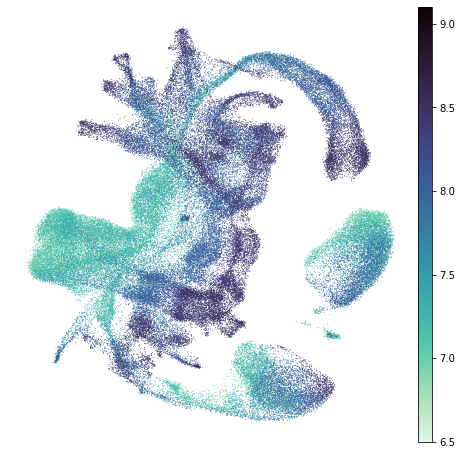

<Figure size 432x288 with 0 Axes>

In [696]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.embedding(model_data, ax = ax, **day_umap_kwargs, s =3, basis = 'X_author_umap')
plt.savefig('figure3/author/day.png', bbox_inches = 'tight', dpi = 300)